# Exercise Sheet 2 – MLP, Learning rate, Overfitting, and Hyper-parameters.

# Introduction

In this task you will implement an MLP model for virtual sensing using the flood dataset. 
The objectives are:
- Implementing an MLP model via TensorFlow Functional API.
- Getting more familiar with model fitting and overfitting.
- Implementing early stopping.
- Exploring hyperparameters and their influence.
- Selecting model architecture.

## Imports

In [2]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 24
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## System checks


In [3]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(gpus)
print(cpus)

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Choose your device for computation. CPU or one of your CUDA devices

In [4]:
tf.config.set_visible_devices(gpus, 'GPU')

# Subtask 2.1

## Backpropagation – Chain Rule

### Model
Let us assume an MLP with one hidden layer containing one neuron with `sigmoid` function ($S(x) = 1 / (1 + e^{-x})$) as the activation function. The input and the output dimensions are equal to one. The activation function for the input and output layers is `linear`.
The mapping $f: x \to \tilde{y}$ from the input $x$ to output $\tilde{y}$ can be written as:
\begin{equation}
\tilde{y} = f(x) = w_2 S(w_1 x)
\end{equation}
where $w_1$ and $w_2$ are the weights of the model. Note that we do not have bias for this example. Let us consider mean-squared error as the loss function. The loss $\ell$ can be obtained as:
\begin{equation}
\ell = (y - \tilde{y})^2 = (y - w_2 S(w_1 x))^2 
\end{equation}
where $y$ denotes the reference label. Let's initialize the weights as $w_1 = 0.1$ and $w_2 = 0.1$.

### Data

Let's assume we have a data set containing three samples as: $x = [1.0, 2.0, 3.0]^{T}$ and $y = [1.0, 4.0, 9.0]^{T}$.

#### TODO
 - Perform gradient descent by hand with a learning rate of 0.1. Train the model for 1 epoch with the batch size of 1.
 - Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

#### TODO
- Define two functions that compute the gradients of the loss with respect to $w_1$ and $w_2$ using analytical differentiation and chain rule.
- Use the functions you defined and train the model again using gradient descent and the same learning rate.
- Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

In [5]:
####################
## YOUR CODE HERE ##
####################
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def forward(x, w1, w2):
    z1 = x*w1
    a1 = sigmoid(z1)
    a2 = a1 * w2
    z2 = a2
    yhat = z2
    return yhat


def loss(y, yhat):
    return (y - yhat)**2


def gradient_w1(x, y, w1, w2):
    dlda2 = -2*(y-forward(x, w1, w2)) 
    da2dz2 = 1
    dz2da1 = w2
    z1 = x*w1
    da1dz1 = sigmoid(z1)*(1 -sigmoid(z1))
    dz1dw1 = x
    return dlda2 * da2dz2 * dz2da1 * da1dz1 * dz1dw1

def gradient_w2(x, y, w1, w2):
    dlda2 = -2*(y-forward(x, w1, w2)) 
    da2dz2 = 1
    z1 = x*w1
    a1 = sigmoid(z1)
    dz2dw2 = a1
    return dlda2 * da2dz2 * dz2dw2


def update_w(old_w1, old_w2, dlw1, dlw2, lr=0.1):
    w1 = old_w1 - lr * dlw1
    w2 = old_w2 - lr * dlw2
    return w1, w2

X = [1, 2, 3]
y = [1, 4, 9]
w1 = 0.1
w2 = 0.1 
for input_, label in zip(X, y):
    y_hat = forward(input_, w1, w2)
    losses_ = loss(label, y_hat)
    dw1 = gradient_w1(input_, label, w1, w2)
    dw2 = gradient_w2(input_, label, w1, w2)
    w1, w2 = update_w(w1, w2, dw1, dw2)
    print(f'True X= {input_:0.3f} | True y= {label:0.3f} | Pred y= {y_hat:0.3f} | w1= {w1:0.3f} | w2= {w2:0.3f} | loss= {losses_:0.3f}')

True X= 1.000 | True y= 1.000 | Pred y= 0.052 | w1= 0.105 | w2= 0.199 | loss= 0.898
True X= 2.000 | True y= 4.000 | Pred y= 0.110 | w1= 0.181 | w2= 0.629 | loss= 15.131
True X= 3.000 | True y= 9.000 | Pred y= 0.398 | w1= 0.936 | w2= 1.718 | loss= 73.993


#### TODO
- Use automatic differentiation (AD) (`tf.GradientTape`) to compute the gradients.
- Train the model again using the same learning rate, epoch, and batch size.
- Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

In [6]:
####################
## YOUR CODE HERE ##
####################
import tensorflow as tf

def gradient_w1(x, y, w1, w2):
    with tf.GradientTape() as tape:
        z1 = w1 * x
        a1 = tf.sigmoid(z1)
        a2 = w2 * a1
        z2 = a2
        loss = tf.reduce_mean((y-z2) ** 2)
    gradients = tape.gradient(loss, w1)
    return gradients

def gradient_w2(x, y, w1, w2):
    with tf.GradientTape() as tape:
        z1 = w1 * x
        a1 = tf.sigmoid(z1)
        a2 = w2 * a1
        z2 = a2
        loss = tf.reduce_mean((y-z2) ** 2)
    gradients = tape.gradient(loss, w2)
    return gradients



def update_w(old_w1, old_w2, dlw1, dlw2, lr=0.1):
    w1 = old_w1 - lr * dlw1
    w2 = old_w2 - lr * dlw2
    return w1, w2


X = tf.convert_to_tensor([1.0, 2.0, 3.0])
y = tf.convert_to_tensor([1.0, 4.0, 9.0])
w1 = tf.Variable([0.1])
w2 = tf.Variable([0.1])
for input_, label in zip(X, y):
    y_hat = forward(input_, w1, w2)
    losses_ = loss(label, y_hat)
    dw1 = gradient_w1(input_, label, w1, w2)
    dw2 = gradient_w2(input_, label, w1, w2)

    w1, w2 = update_w(w1, w2, dw1.numpy()[0], dw2.numpy()[0])
    w1 = tf.Variable(w1)
    w2 = tf.Variable(w2)
    print('True X=', input_.numpy(), ' | ', 'True y=', label.numpy(), ' | ', 'Pred y=', y_hat.numpy(), ' | ', 'w1= ', w1.numpy(), ' | ', 'w2= ', w2.numpy(), ' | ', 'loss= ', losses_.numpy())


True X= 1.0  |  True y= 1.0  |  Pred y= [0.05249792]  |  w1=  [0.10472569]  |  w2=  [0.19948378]  |  loss=  [0.8977602]
True X= 2.0  |  True y= 4.0  |  Pred y= [0.11014941]  |  w1=  [0.18147705]  |  w2=  [0.6290573]  |  loss=  [15.130938]
True X= 3.0  |  True y= 9.0  |  Pred y= [0.39809424]  |  w1=  [0.93584657]  |  w2=  [1.7177879]  |  loss=  [73.99278]


# Subtask 2.2

In this task, we consider the data from **Margarethenklippe** as the input and train an MLP that gives the information about **Sennhuette** as the output. For each of the sensors, we have the water level, **W**, and the mass flow rate, **Q**, every 15 minutes.
## Pre-processing 

#### TODO
 - Load the flood dataset (`Flood_Data.csv`) using *pandas* library.
 - Drop the first four columns of the DataFrame and columns containing NaNs.
 - Split the data into inputs and outputs.
 - Shuffle the data and get the NumPy arrays.
 - Split the data to 75% for training, 15% for validation, and 15% for testing.
 - Standardize inputs and outputs. 
 

In [7]:
# TODO load the flood dataset using pandas

####################
## YOUR CODE HERE ##
####################
df = pd.read_csv('Flood_Data.csv', sep=';')

cols = [0, 1, 2, 3]
df.drop(df.columns[cols],axis=1,inplace=True)
df.dropna(axis=1, how='all', inplace=True)

df.head(5)


,MargarethenklippeMin15W,MargarethenklippeMin15Q,SennhuetteMin15W,SennhuetteMin15Q
0,7.3,0.037909,4.4,0.031730
1,7.3,0.037909,4.3,0.030458
2,7.2,0.036720,4.4,0.031730
3,7.2,0.036720,4.5,0.033025
4,7.2,0.036720,4.4,0.031730


In [8]:
# TODO split the data into inputs X and outputs y
####################
## YOUR CODE HERE ##
####################

#N_samples = X.shape[0] # number of samples
np_array = df.values
X, y = np_array[:, :2], np_array[:, 2:]

In [9]:
# TODO shuffle the data and get the NumPy arrays:
####################
## YOUR CODE HERE ##
####################
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]


# TODO split the data to train, validation, and test:
####################
## YOUR CODE HERE ##
####################

total_samples = len(np_array)
train_samples = int(0.75 * total_samples)
val_samples = int(0.15 * total_samples)
test_samples = int(0.15 * total_samples)
X_train = X[:train_samples, :]
y_train = y[:train_samples, :]

X_val = X[train_samples:train_samples+val_samples, :]
y_val = y[train_samples:train_samples+val_samples, :]

X_test = X[train_samples+val_samples:, :]
y_test = y[train_samples+val_samples:, :]

Let us define a class for standardizing the data. We will implement a function that applies the scaling (`apply`) and a function that maps the scaled data back into the original scale (`apply_reverse`). 

In [10]:
# TODO create a class for standardizing the data.

####################
## YOUR CODE HERE ##
####################
class Standarization():
    
    def __init__(self) -> None:
        self.mean_X = None
        self.std_X = None
        self.mean_y = None
        self.std_y = None
    
    def fit(self, X, y):
        self.mean_X = np.mean(X, axis=0)
        self.std_X = np.std(X, axis=0)
        self.mean_y = np.mean(y)
        self.std_y = np.std(y)

    def transform(self, X, y):
        X_scaled = (X - self.mean_X) / self.std_X
        y_scaled = (y - self.mean_y) / self.std_y
        return X_scaled, y_scaled

In [11]:
# TODO standardize the data using the class you defined in the cell above.

####################
## YOUR CODE HERE ##
####################
stander=Standarization()
stander.fit(X_train, y_train)

X_train, y_train = stander.transform(X_train, y_train)
X_val, y_val = stander.transform(X_val, y_val)
X_test, y_test = stander.transform(X_test, y_test)

# Subtask 2.3

## Implementing an MLP using TensorFlow Functional API.

#### TODO

- Implement an MLP using TensorFlow Functional API. 
- Print the model architecture using `model.summary()`.

In [45]:
# TODO implement the model 

def MLP(N_hidden_layers, N_neurons, activation):
    input_layer = layers.Input(shape = (2))
    x = input_layer
    for i in range(N_hidden_layers):
        x = layers.Dense(N_neurons, activation = activation)(x)
    output_layer = layers.Dense(2)(x)

    model = models.Model(input_layer, output_layer)
    return model

####################
## YOUR CODE HERE ##
####################
model = MLP(2, 10, tf.nn.relu)

In [46]:
# TODO print the model architecture
####################
## YOUR CODE HERE ##
####################
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_15 (Dense)            (None, 10)                30        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 2)                 22        
                                                                 
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


# Subtask 2.4

## Optimizer, loss function and training

#### TODO

- Define the optimizer and the loss function using `tf.keras.optimizers` and `tf.keras.losses`, respectively. 
    - Use stochastic gradient descent (SGD) with a learning rate of 1.0 as the optimizer.
    - Use mean-squared error as the loss function.
- Compile the model using the optimizer and the loss.
- Train the model and get the history of training and validation losses.
    - Train the model for 10 epochs.
    - Use a batch size of 512.
- Plot the learning curves.

In [47]:
# TODO define the optimizer and the loss function
####################
## YOUR CODE HERE ##
####################
optimizer = optimizers.SGD(learning_rate=1.0)
loss = losses.MeanSquaredError()

# TODO compile the model
####################
## YOUR CODE HERE ##
####################
model.compile(optimizer = optimizer, loss = loss)

In [48]:
# TODO train the model 
####################
## YOUR CODE HERE ##
####################
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5652 - val_loss: 0.5612
Epoch 2/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5605 - val_loss: 0.5676
Epoch 3/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5606 - val_loss: 0.5714
Epoch 4/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5606 - val_loss: 0.5606
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5605 - val_loss: 0.5608
Epoch 6/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5606 - val_loss: 0.5646
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5608 - val_loss: 0.5606
Epoch 8/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5607 - val_loss: 0.5690
Epoch 9/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5607 - val_loss: 0.5620
Epoch 10/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5607 - val_loss: 0.5604

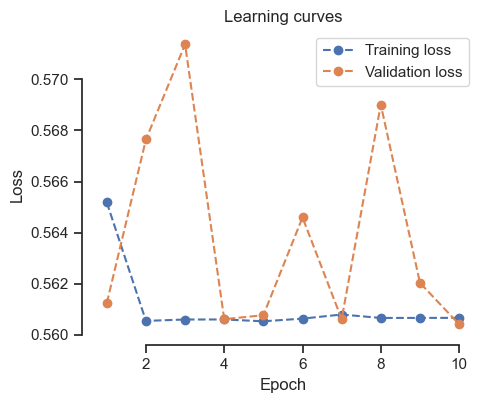

In [49]:

def plot_learning_curves(hist):
    epochs = np.arange(0, len(hist.history['loss'])) + 1
    sns.set(style='ticks')
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))
    ax.plot(epochs, hist.history['loss'], label = 'Training loss', marker = 'o', ls = '--')
    ax.plot(epochs, hist.history['val_loss'], label = 'Validation loss', marker = 'o', ls = '--')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Learning curves')
    ax.legend()
    sns.despine(trim=True, offset=5)

# TODO Use the function above to plot the learning curves
####################
## YOUR CODE HERE ##
####################
plot_learning_curves(hist)

# Subtask 2.5

## Learning rate

#### TODO
- Decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train.
    - Train the model for 10 epochs.
    - Use a batch size of 512.
- Plot the training curves of the loss and the accuracies as in Subtask 1.3. Use the function defined above.


Epoch 1/10
754/754 [==============================] - 1s 975us/step - loss: 0.5596 - val_loss: 0.5606
Epoch 2/10
754/754 [==============================] - 1s 988us/step - loss: 0.5596 - val_loss: 0.5604
Epoch 3/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.5604
Epoch 4/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.5604
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.5606
Epoch 6/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.5604
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.5604
Epoch 8/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.5605
Epoch 9/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.5604
Epoch 10/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5596 - val_loss: 0.

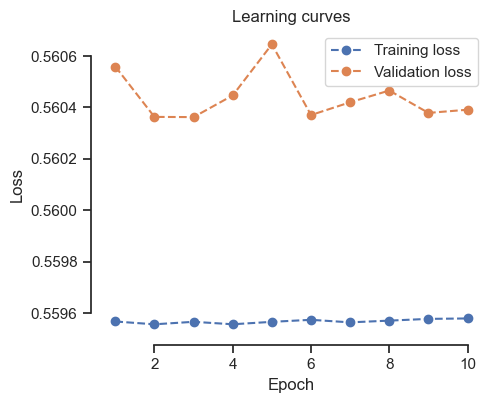

In [19]:
# learning rate = 0.1
####################
## YOUR CODE HERE ##
####################

optimizer = optimizers.SGD(learning_rate=0.1)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

Epoch 1/10
754/754 [==============================] - 1s 982us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 2/10
754/754 [==============================] - 1s 973us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 3/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 4/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 6/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 8/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 9/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 10/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.

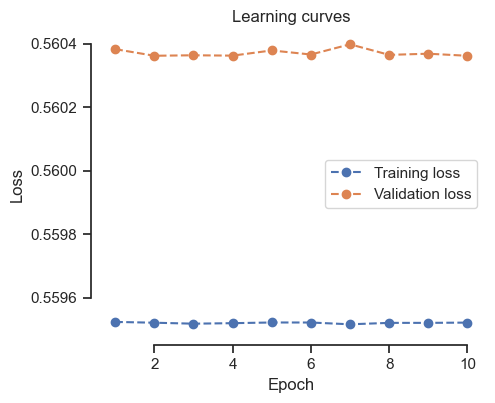

In [20]:
# learning rate = 0.01
####################
## YOUR CODE HERE ##
####################
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

Epoch 1/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 2/10
754/754 [==============================] - 1s 910us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 3/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 4/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 6/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 8/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 9/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 10/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.56

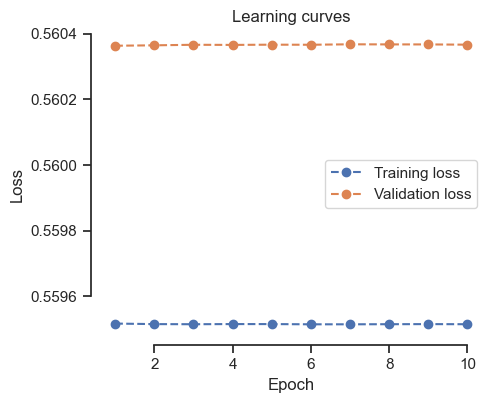

In [21]:
optimizer = optimizers.SGD(learning_rate=0.001)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

Epoch 1/10
754/754 [==============================] - 1s 963us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 2/10
754/754 [==============================] - 1s 916us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 3/10
754/754 [==============================] - 1s 983us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 4/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 6/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 8/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 9/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 10/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 

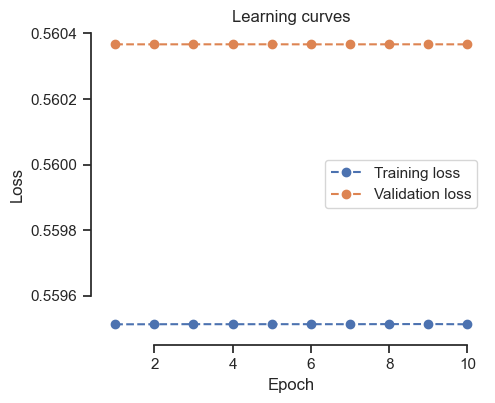

In [22]:
# learning rate = 1e-4
####################
## YOUR CODE HERE ##
####################
optimizer = optimizers.SGD(learning_rate= 1e-4)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

## Model selection

Is it the lowest validation loss that one can achieve? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs and plot the learning curves. Use learning rate of 0.01.

#### TODO from now on, for all subsequent tasks:
- Print the overall best validation loss and the epoch at which it occurred of.


Epoch 1/100
754/754 [==============================] - 1s 941us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 2/100
754/754 [==============================] - 1s 830us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 3/100
754/754 [==============================] - 1s 850us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 4/100
754/754 [==============================] - 1s 836us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 5/100
754/754 [==============================] - 1s 834us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 6/100
754/754 [==============================] - 1s 863us/step - loss: 0.5595 - val_loss: 0.5604
Epoch 7/100
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 8/100
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 9/100
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 10/100
754/754 [==============================] - 1s 1ms/step - loss: 0.5

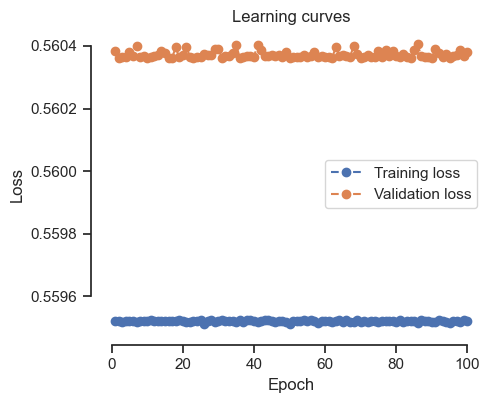

In [23]:
optimizer = optimizers.SGD(learning_rate= 0.01)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 100, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

In [24]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.5604
Epoch of Best Validation Loss: 10


# Subtask 2.6
## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk.
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Evaluate `model2` on the validation dataset.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation loss again. It should be of the exact same value as `model`'s validation loss.


Epoch 1/100
705/754 [===========================>..] - ETA: 0s - loss: 0.5612
Epoch 1: val_loss improved from inf to 0.56038, saving model to model_checkpoint.h5
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 2/100
713/754 [===========================>..] - ETA: 0s - loss: 0.5599
Epoch 2: val_loss improved from 0.56038 to 0.56036, saving model to model_checkpoint.h5
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 3/100
741/754 [============================>.] - ETA: 0s - loss: 0.5591
Epoch 3: val_loss did not improve from 0.56036
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 4/100
729/754 [============================>.] - ETA: 0s - loss: 0.5597
Epoch 4: val_loss did not improve from 0.56036
754/754 [==============================] - 1s 1ms/step - loss: 0.5595 - val_loss: 0.5604
Epoch 5/100
726/754 [===========================>..] - ETA: 0s - l

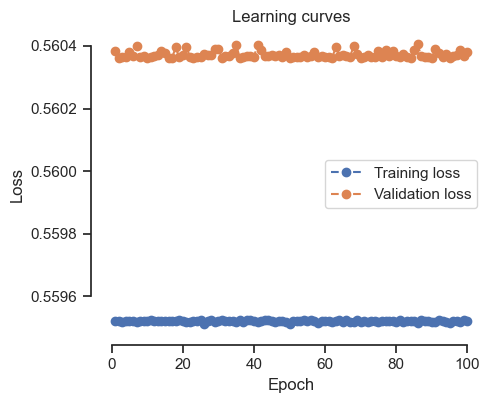

In [34]:
####################
## YOUR CODE HERE ##
####################
import os


optimizer = optimizers.SGD(learning_rate= 0.01)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



hist = model.fit(X_train, 
          y_train,  
          epochs=100,
          validation_data=(X_val, y_val),
          callbacks=[checkpoint_callback],
          batch_size=512, 
         )


plot_learning_curves(hist)


In [35]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.5604
Epoch of Best Validation Loss: 10


In [38]:
model2 = MLP(2, 10, tf.nn.sigmoid)
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model2.compile(optimizer=optimizer, loss=loss)
model2.evaluate(X_val, y_val, verbose=2)

2411/2411 - 1s - loss: 1.0044 - 1s/epoch - 560us/step


1.0044358968734741

In [39]:
model2.load_weights('model_checkpoint.h5')
model2.evaluate(X_val, y_val, verbose=2)

2411/2411 - 1s - loss: 1.3388 - 1s/epoch - 520us/step


1.3388004302978516

# Subtask 2.7
## Early stopping
So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.

### TODO
- Implement Early Stopping using `tf.keras.callbacks.EarlyStopping`. Use patience = 5, which means that if the validation loss is not improved after 5 epochs, the training process should be stopped.
- Save the model checkpoint after each epoch if the validation loss is improved. Use `tf.keras.callbacks.ModelCheckpoint`.
- Train the model for 100 epochs with a learning rate of 0.01.
- Load the model checkpoint.
- Evaluate the model on the validation data.

Epoch 1/100
749/754 [============================>.] - ETA: 0s - loss: 0.5178
Epoch 1: val_loss improved from inf to 0.42232, saving model to model_checkpoint_1.h5
754/754 [==============================] - 1s 1ms/step - loss: 0.5172 - val_loss: 0.4223
Epoch 2/100
718/754 [===========================>..] - ETA: 0s - loss: 0.3213
Epoch 2: val_loss improved from 0.42232 to 0.20779, saving model to model_checkpoint_1.h5
754/754 [==============================] - 1s 1ms/step - loss: 0.3159 - val_loss: 0.2078
Epoch 3/100
716/754 [===========================>..] - ETA: 0s - loss: 0.1475
Epoch 3: val_loss improved from 0.20779 to 0.11211, saving model to model_checkpoint_1.h5
754/754 [==============================] - 1s 1ms/step - loss: 0.1462 - val_loss: 0.1121
Epoch 4/100
718/754 [===========================>..] - ETA: 0s - loss: 0.1039
Epoch 4: val_loss improved from 0.11211 to 0.09827, saving model to model_checkpoint_1.h5
754/754 [==============================] - 1s 1ms/step - loss: 0.

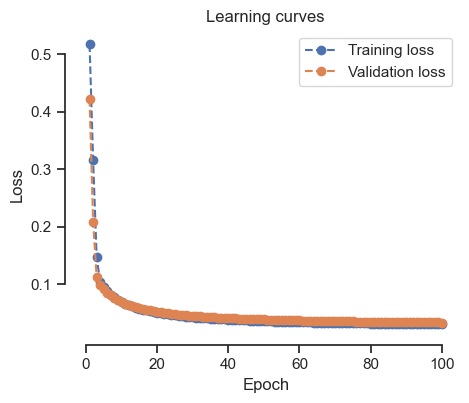

In [57]:

model =MLP(2, 10, tf.nn.sigmoid)
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)



early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_1.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping_callback, checkpoint_callback],
    batch_size=512
)


model.load_weights('model_checkpoint_1.h5')

val_loss = model.evaluate(X_val, y_val)

print("Validation Loss:", val_loss)


plot_learning_curves(hist)


In [58]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.0330
Epoch of Best Validation Loss: 100


In [59]:
model2 = MLP(2, 10, tf.nn.sigmoid)
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model2.compile(optimizer=optimizer, loss=loss)
model2.evaluate(X_val, y_val, verbose=2)

2411/2411 - 1s - loss: 1.5928 - 1s/epoch - 533us/step


1.5927661657333374

In [60]:
model2.load_weights('model_checkpoint_1.h5')
model2.evaluate(X_val, y_val, verbose=2)

2411/2411 - 1s - loss: 0.0330 - 1s/epoch - 526us/step


0.033044978976249695

Epoch 1/100
740/754 [============================>.] - ETA: 0s - loss: 0.5004
Epoch 1: val_loss improved from inf to 0.43261, saving model to model_checkpoint_2.h5
754/754 [==============================] - 1s 995us/step - loss: 0.4984 - val_loss: 0.4326
Epoch 2/100
709/754 [===========================>..] - ETA: 0s - loss: 0.3423
Epoch 2: val_loss improved from 0.43261 to 0.23044, saving model to model_checkpoint_2.h5
754/754 [==============================] - 1s 967us/step - loss: 0.3356 - val_loss: 0.2304
Epoch 3/100
718/754 [===========================>..] - ETA: 0s - loss: 0.1612
Epoch 3: val_loss improved from 0.23044 to 0.11811, saving model to model_checkpoint_2.h5
754/754 [==============================] - 1s 928us/step - loss: 0.1597 - val_loss: 0.1181
Epoch 4/100
730/754 [============================>.] - ETA: 0s - loss: 0.1076
Epoch 4: val_loss improved from 0.11811 to 0.10091, saving model to model_checkpoint_2.h5
754/754 [==============================] - 1s 920us/step - 

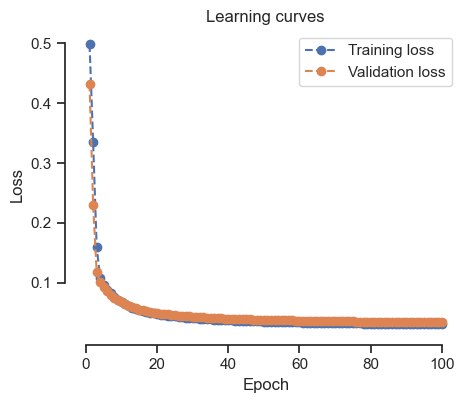

In [61]:
####################
## YOUR CODE HERE ##
####################

model =MLP(2, 10, tf.nn.sigmoid)
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)



early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_2.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping_callback, checkpoint_callback],
    batch_size=512
)


model.load_weights('model_checkpoint_1.h5')

val_loss = model.evaluate(X_val, y_val)

print("Validation Loss:", val_loss)


plot_learning_curves(hist)



In [62]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.0337
Epoch of Best Validation Loss: 100


In [63]:
model2 = MLP(2, 10, tf.nn.sigmoid)
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model2.compile(optimizer=optimizer, loss=loss)
model2.evaluate(X_val, y_val, verbose=2)

2411/2411 - 1s - loss: 1.0457 - 1s/epoch - 546us/step


1.0457370281219482

In [64]:
model2.load_weights('model_checkpoint_1.h5')
model2.evaluate(X_val, y_val, verbose=2)

2411/2411 - 1s - loss: 0.0330 - 1s/epoch - 538us/step


0.033044978976249695

## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 1024 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 (from above) and 1024 
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

2. when batch size is 1 the training is slow.


In [68]:
import time


385596/385632 [============================>.] - ETA: 0s - loss: 0.0402
Epoch 1: val_loss improved from inf to 0.04473, saving model to model_checkpoint_3.h5
385632/385632 [==============================] - 309s 799us/step - loss: 0.0402 - val_loss: 0.0447
Time taken for fitting: 308.59 seconds
2411/2411 [==============================] - 2s 661us/step - loss: 0.0330
Validation Loss: 0.033044978976249695


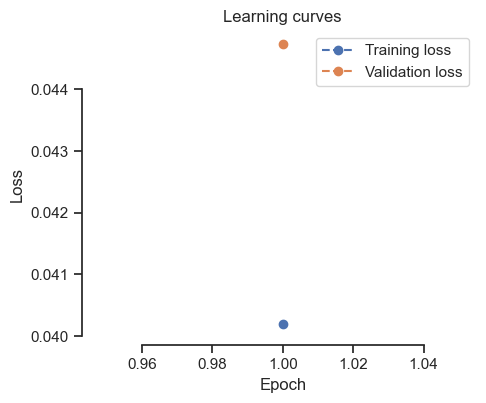

In [69]:
####################
## YOUR CODE HERE ##
####################

model =MLP(2, 10, tf.nn.sigmoid)
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)



early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_3.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
start_time = time.time()

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    callbacks=[early_stopping_callback, checkpoint_callback],
    batch_size=1
)

end_time = time.time()


elapsed_time = end_time - start_time

print("Time taken for fitting: {:.2f} seconds".format(elapsed_time))

model.load_weights('model_checkpoint_3.h5')

val_loss = model.evaluate(X_val, y_val)

print("Validation Loss:", val_loss)


plot_learning_curves(hist)



Epoch 1/100
349/377 [==========================>...] - ETA: 0s - loss: 0.5056
Epoch 1: val_loss improved from inf to 0.46987, saving model to model_checkpoint_4.h5
377/377 [==============================] - 1s 1ms/step - loss: 0.5020 - val_loss: 0.4699
Epoch 2/100
360/377 [===========================>..] - ETA: 0s - loss: 0.4317
Epoch 2: val_loss improved from 0.46987 to 0.38395, saving model to model_checkpoint_4.h5
377/377 [==============================] - 0s 1ms/step - loss: 0.4292 - val_loss: 0.3840
Epoch 3/100
356/377 [===========================>..] - ETA: 0s - loss: 0.3314
Epoch 3: val_loss improved from 0.38395 to 0.27230, saving model to model_checkpoint_4.h5
377/377 [==============================] - 0s 1ms/step - loss: 0.3293 - val_loss: 0.2723
Epoch 4/100
356/377 [===========================>..] - ETA: 0s - loss: 0.2233
Epoch 4: val_loss improved from 0.27230 to 0.17413, saving model to model_checkpoint_4.h5
377/377 [==============================] - 0s 1ms/step - loss: 0.

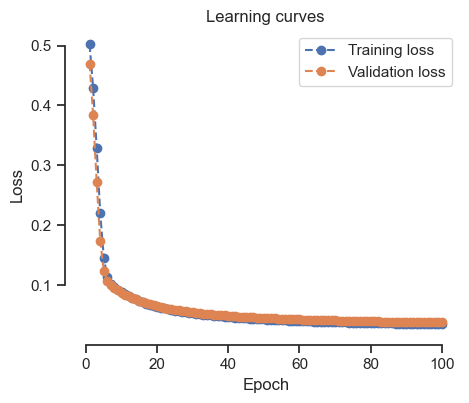

In [71]:
####################
## YOUR CODE HERE ##
####################

model =MLP(2, 10, tf.nn.sigmoid)
optimizer = optimizers.SGD(learning_rate=0.01)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)



early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_4.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
start_time = time.time()

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping_callback, checkpoint_callback],
    batch_size=1024
)

end_time = time.time()


elapsed_time = end_time - start_time

print("Time taken for fitting: {:.2f} seconds".format(elapsed_time))

model.load_weights('model_checkpoint_4.h5')

val_loss = model.evaluate(X_val, y_val)

print("Validation Loss:", val_loss)


plot_learning_curves(hist)



# Subtask 2.8
## What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of hidden layers
- number of neurons per each hidden layer
- activation function 

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

Epoch 1/10
754/754 [==============================] - 1s 1ms/step - loss: 0.7601 - val_loss: 0.6007
Epoch 2/10
754/754 [==============================] - 1s 1ms/step - loss: 0.5388 - val_loss: 0.4962
Epoch 3/10
754/754 [==============================] - 1s 1ms/step - loss: 0.4607 - val_loss: 0.4251
Epoch 4/10
754/754 [==============================] - 1s 1ms/step - loss: 0.3780 - val_loss: 0.3243
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 0.2488 - val_loss: 0.1677
Epoch 6/10
754/754 [==============================] - 1s 1ms/step - loss: 0.1007 - val_loss: 0.0591
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 0.0508 - val_loss: 0.0454
Epoch 8/10
754/754 [==============================] - 1s 1ms/step - loss: 0.0446 - val_loss: 0.0422
Epoch 9/10
754/754 [==============================] - 1s 1ms/step - loss: 0.0426 - val_loss: 0.0407
Epoch 10/10
754/754 [==============================] - 1s 1ms/step - loss: 0.0412 - val_loss: 0.0395

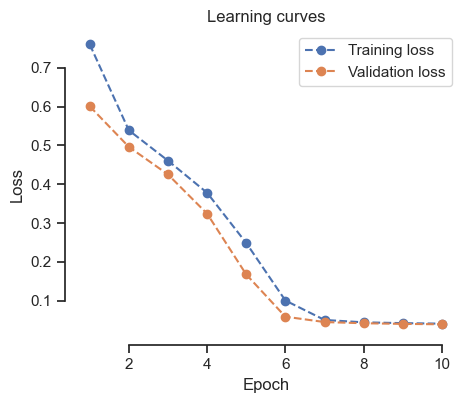

In [77]:
# number of hidden layers

####################
## YOUR CODE HERE ##
####################

# 4 hidden layers
model = MLP(4, 10, tf.nn.relu)
optimizer = optimizers.SGD(learning_rate=0.001)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

In [78]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.0395
Epoch of Best Validation Loss: 10


Epoch 1/10
754/754 [==============================] - 3s 3ms/step - loss: 0.3321 - val_loss: 0.0883
Epoch 2/10
754/754 [==============================] - 3s 3ms/step - loss: 0.0684 - val_loss: 0.0521
Epoch 3/10
754/754 [==============================] - 3s 3ms/step - loss: 0.0457 - val_loss: 0.0388
Epoch 4/10
754/754 [==============================] - 2s 3ms/step - loss: 0.0359 - val_loss: 0.0328
Epoch 5/10
754/754 [==============================] - 3s 3ms/step - loss: 0.0314 - val_loss: 0.0301
Epoch 6/10
754/754 [==============================] - 3s 3ms/step - loss: 0.0292 - val_loss: 0.0288
Epoch 7/10
754/754 [==============================] - 2s 3ms/step - loss: 0.0281 - val_loss: 0.0283
Epoch 8/10
754/754 [==============================] - 2s 3ms/step - loss: 0.0275 - val_loss: 0.0279
Epoch 9/10
754/754 [==============================] - 2s 3ms/step - loss: 0.0271 - val_loss: 0.0277
Epoch 10/10
754/754 [==============================] - 2s 3ms/step - loss: 0.0269 - val_loss: 0.0275

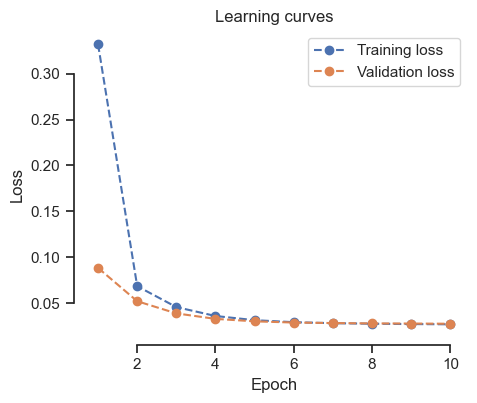

In [79]:
# number of neurons per each hidden layer

####################
## YOUR CODE HERE ##
####################

# 100 neurons
model = MLP(2, 100, tf.nn.relu)
optimizer = optimizers.SGD(learning_rate=0.001)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

In [80]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.0275
Epoch of Best Validation Loss: 10


Epoch 1/10
754/754 [==============================] - 1s 1ms/step - loss: 0.3862 - val_loss: 0.1559
Epoch 2/10
754/754 [==============================] - 1s 981us/step - loss: 0.1292 - val_loss: 0.1167
Epoch 3/10
754/754 [==============================] - 1s 997us/step - loss: 0.1122 - val_loss: 0.1086
Epoch 4/10
754/754 [==============================] - 1s 1ms/step - loss: 0.1053 - val_loss: 0.1026
Epoch 5/10
754/754 [==============================] - 1s 1ms/step - loss: 0.0996 - val_loss: 0.0976
Epoch 6/10
754/754 [==============================] - 1s 991us/step - loss: 0.0949 - val_loss: 0.0933
Epoch 7/10
754/754 [==============================] - 1s 1ms/step - loss: 0.0908 - val_loss: 0.0896
Epoch 8/10
754/754 [==============================] - 1s 981us/step - loss: 0.0874 - val_loss: 0.0865
Epoch 9/10
754/754 [==============================] - 1s 979us/step - loss: 0.0845 - val_loss: 0.0839
Epoch 10/10
754/754 [==============================] - 1s 980us/step - loss: 0.0820 - val_

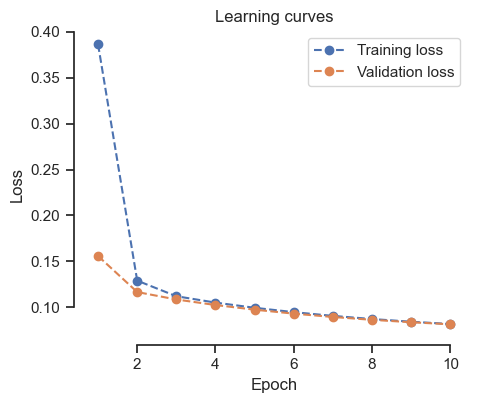

In [81]:
# activation function

####################
## YOUR CODE HERE ##
####################

# Use tanh instead of ReLU
model = MLP(2, 10, tf.nn.tanh)
optimizer = optimizers.SGD(learning_rate=0.001)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 512
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

In [82]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.0816
Epoch of Best Validation Loss: 10


# Subtask 2.9
## Challenge
#### TODO
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?

Epoch 1/10
12051/12051 [==============================] - 12s 997us/step - loss: 0.3049 - val_loss: 0.0791
Epoch 2/10
12051/12051 [==============================] - 12s 1ms/step - loss: 0.0571 - val_loss: 0.0414
Epoch 3/10
12051/12051 [==============================] - 13s 1ms/step - loss: 0.0362 - val_loss: 0.0323
Epoch 4/10
12051/12051 [==============================] - 13s 1ms/step - loss: 0.0306 - val_loss: 0.0298
Epoch 5/10
12051/12051 [==============================] - 13s 1ms/step - loss: 0.0287 - val_loss: 0.0288
Epoch 6/10
12051/12051 [==============================] - 13s 1ms/step - loss: 0.0278 - val_loss: 0.0282
Epoch 7/10
12051/12051 [==============================] - 13s 1ms/step - loss: 0.0272 - val_loss: 0.0278
Epoch 8/10
12051/12051 [==============================] - 13s 1ms/step - loss: 0.0268 - val_loss: 0.0275
Epoch 9/10
12051/12051 [==============================] - 13s 1ms/step - loss: 0.0266 - val_loss: 0.0274
Epoch 10/10
12051/12051 [============================

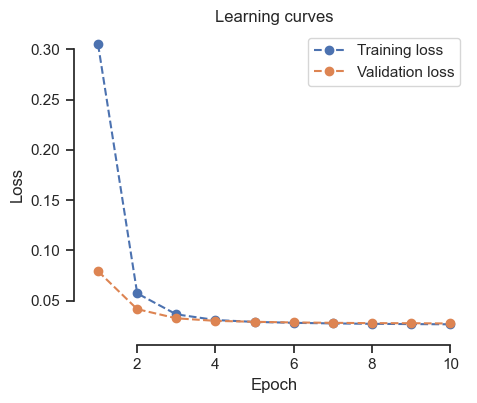

In [83]:
# Your best model:

####################
## YOUR CODE HERE ##
####################
model = MLP(4, 100, tf.nn.relu)
optimizer = optimizers.SGD(learning_rate=0.0001)
loss = losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = loss)
batch_size = 32
hist = model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, validation_data = (X_val, y_val))
plot_learning_curves(hist)

In [84]:
best_val_loss = min(hist.history['val_loss'])
best_epoch = hist.history['val_loss'].index(best_val_loss) + 1

print("Best Validation Loss: {:.4f}".format(best_val_loss))
print("Epoch of Best Validation Loss: {}".format(best_epoch))

Best Validation Loss: 0.0272
Epoch of Best Validation Loss: 10


# Subtask 2.10
## Evaluate your best model on test set, once!
When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- Evaluate the model on the testing dataset.
- Plot the reference mass flow rate vs. the predicted values for the first 50 samples of the testing dataset.

In [85]:
# TODO evaluate the model
####################
## YOUR CODE HERE ##
####################
model.evaluate(X_test, y_test)

1607/1607 [==============================] - 1s 656us/step - loss: 0.0276


0.027551688253879547

1607/1607 [==============================] - 1s 589us/step


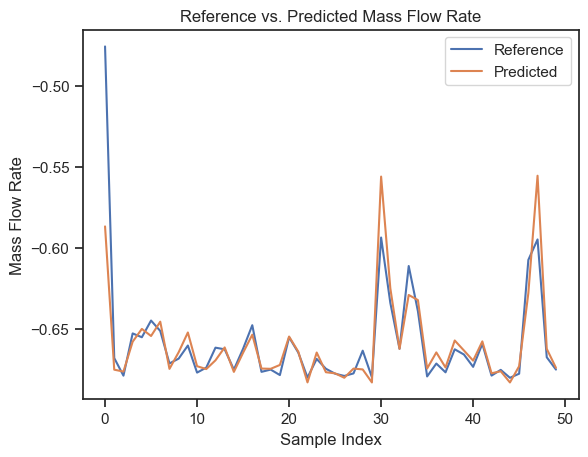

In [86]:
# TODO plot results
####################
## YOUR CODE HERE ##
####################
import matplotlib.pyplot as plt



predictions = model.predict(X_test)

# Extract the reference mass flow rate values for the first 50 samples
reference_values = y_test[:50]

# Extract the predicted values for the first 50 samples
predicted_values = predictions[:50]

# Create the plot
plt.plot(reference_values[:, 1], label='Reference')
plt.plot(predicted_values[:, 1], label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Mass Flow Rate')
plt.title('Reference vs. Predicted Mass Flow Rate')
plt.legend()
